# Reforestation in South America

Deforestation is one of the world's greatest threats, contributing to climate change, a loss of biodiversity, and diminishing resources for Earth's billions of human inhabitants. Forests represent nearly 30% of our world's land cover, yet 502,000 square miles of forest have been cleared in the past twenty years -- an area nearly twice the size of Texas.<sup>1</sup> 

The Amazon has been described as the "Lungs of our Planet" because it absorbs over 20% of global carbon-dioxide and converts it to oxygen. Likewise, it is home to over half of all species of flora and fauna known to mankind. Yet, as an environment that largely contributes to reducing climate change and preserving biodiversity, nearly 17% of the rainforest has been lost already. Earlier this fall,  nearly four-hundred thousand fires burned throughout the Amazon rainforest, drawing international attention to the deforestation crisis. Policies in Brazil supported landowners to burn away the forest for agricultural and developmental use on the land. Unless government policies change to illegalize deforestation, environmentalists predict that we will see even larger contribution to the destruction of our forests in the coming years. If society continues down this path, our lives would change drastically with rapidly rising oceans, spiking temperatures, changes in weather patterns, and a loss of wood/paper/medicinal resources. <sup>2

For this reason, a global reforestation effort is required to mitigate these averse outcomes (along with governmental policies inhibiting deforestation). The present project plans to provide a concrete and actionable plan for reforestation in South America (which can also be extrapolated to other global regions). Using satellite data from Google Earth, we will build a model that accurately predicts the location of forests based on geophysical and meteorological data. We then use that model to identify areas that are not currently forested that would be maximally viable for reforestation. 

## Table of Contents

[Google Earth Engine Setup](#Google-Earth-Engine-Setup)

[Visualizing Global Land Cover](#Visualizing-Global-Land-Cover)

[Collecting Potential Features](#Collecting-Potential-Features)

[Preparing Data](#Preparing-Data)

[Training A Forest Prediction Model](#Training-A-Forest-Prediction-Model)

[Determining Regions for Reforestation](#Determining-Regions-for-Reforestation)

[Discussion](#Discussion)

[References](#References)

## Google Earth Engine Setup

Throughout the collection of satellite data, our code runs on Google servers as to not overload our local machine. This is best done in Python using Google Colabatory. Colab notebooks are Jupyter notebooks that run in the cloud and are integrated with Google Drive. We used a Colab notebook (not shown) to extract the data that was imported into this notebook, where all the data pre-processing was conducted. 

Google Earth Engine is a cloud-based geospatial processing platform. It has a library of satellite and remotely-sensed imagery and an API for making requests to their servers. You can apply to get access to Google Earth Engine API [here](https://earthengine.google.com/) (It may take a few days for them to approve your use of their resources). Likewise, you can access the API documentation [here](https://developers.google.com/earth-engine), although it is in JavaScript.

The following code installs the API and `earthengine` command line tool using the `pip` installer:

In [1]:
!pip install earthengine-api

Next, we import the Earth Engine API and authenticate our access to the servers. Follow the instructions in the link in the output to complete the authentication instructions with the credentials you signed up with. 

In [7]:
import ee

# Import display methods
from IPython.display import Image
import folium

ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/uAFceWmmAc40d3bOIPdMw1Ue_YJQKROnjPxv9d7ypKeX_sse4jDHsIg

Successfully saved authorization token.


In [5]:
# Import additional libraries:
    
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib import cm
import numpy as np
import os
import string
import time
import pandas as pd
import itertools
import math

from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline
    
from PIL import Image

## Visualizing Global Land Cover

The Google Earth Engine has a Map object that allows a developer to easily visualize and interact with geographic data (nearly identical to the one in Google Map's phone app). Using folium, a python library for mapping data onto leaflet maps (from `leaflet.js` in JavaScript), we can upload data collected about features of Earth's surface and 'layer' it over the initial map. 

To determine where forests exist and where they can be planted, we need to examine the distribution of land cover on Earth's surface. For example, it would be infeasible to grow a forest in an urban region, agricultural region, or a lake! Using a landcover dataset from NASA at the USGS EROS Center that classified satellite data, we visualize the global distribution of different features of land cover. The code below describes which colors coordinate to what regions. Note that as this is a static notebook, and the output is interactive, the actual map displaying is commented out and a screenshot is inserted as the visual. If you are running these cells, you can uncomment the code and interact with the map. 

In [0]:
# Initialize the library
ee.Initialize()

# Define a method for displaying Earth Engine image tiles to folium map.

# The following function is adapted from code online on the GEE tutorial for 
# adding a layer on a map. It can be found here: 
# https://developers.google.com/earth-engine/python_install-colab.html 
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium
folium.Map.add_ee_layer = add_ee_layer

landCover = ee.ImageCollection('MODIS/051/MCD12Q1').select('Land_Cover_Type_1')
cover = ee.Image(landCover.first())

visParams = {
  'min': 0,
  'max': 17,
  'palette': [
  '1c0dff', # water
  '05450a', '086a10', # needeleaf, broadleaf evergreen forest
  '54a708', '30eb5b', #needleleaf, broadlead deciduous forest
  '009900', # mixed forest
  '6a2325', 'c3aa69', # closed, open shrubland
  'b76031', 'd9903d', '91af40',  # woody savannah, savannah, grassland
  '111149', # permanent wetlands
  'cdb33b', '33280d', # croplands, croplands mosaic
  'cc0013', # urban
  'd7cdcc', # snow and ice
  'f7e084', # barren
  '6f6f6f'  # tundra
]}

# If you are running the notebook, uncomment the bottom four lines of code and
# the output will show. As it is interactive, the map is not displayed in a 
# static notebook. I have included a screenshot instead of a zoomed out version
# of the map. 

#coverMap = folium.Map(location=[20, 0], zoom_start=3, height=500)
#coverMap.add_ee_layer(cover.updateMask(cover.gt(0)), visParams, 'Land Cover Classified')
#coverMap.add_child(folium.LayerControl())
#display(coverMap)

<img src="images/LandCoverMap.png" alt="drawing" width="1300"/>

In particular, we want to train our model on data that represents which coordinates cointain forest and which do not. From the ALOS PALSAR, a project classified satellite data into an 'FNF' map (Forest/Not-Forest). We can visualize this data below. Note that as before, the cell will not display statically, so a screenshot is inserted for present visualization. 

In [ ]:
fnfData = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF')
fnfMap = ee.Image(fnfData.first())
Image(url=fnfMap.updateMask(fnfMap.gt(0))
  .getThumbUrl({'min': 1.0, 'max': 3.0, 'dimensions': 1400, 'format' : 'jpg',
                'palette': ['006400', # Forest
                            'FEFF99', # Not Forest
                            '0000FF'  # Water
                            ]}))

<img src="images/fnfMap.png" alt="drawing" width="1100"/>

## Collecting Potential Features


Data on Google Earth Engine comes in the form of Image or ImageCollection (a collection of Image objects) classes. Each of these images is a “map” of the feature of interest over a date range, or averaged over all dates on which data was collected. The datasets and ground truth used for this project were extracted from the Google Earth Engine repository using the following methodology:
- Individual datasets were identified in the Google Earth Engine (GEE) Data Catalog based on likely determinitive climate, topographic, geophysical, and man-made factors related to deforestation and reforestation. <sup>17</sup> 

<img src="images/GEE.png" alt="drawing" width="400"/>



- The selected dataset extraction parameters were obtained by inspecting the dataset specifications, specifically to choose the band and the corresponding value ranges or enumerations. This is the example for the digital elevation dataset, which expresses values from -10 to 6500 meters above sea level. <sup>17</sup>

<img src="images/Dataset.png" alt="drawing" width="600"/>



- An extraction region for the project was defined using geographic coordinates (Longitude: -84.6W to -32.9W, Latitude: 55.9S, to 15.7N) to encompass the entire South American continent. Also, a common geographic extraction size was chosen over that region (1000 rows x 681 columns).


- These (dataset, band, min_value, max_value, region, size) parameters were then used to extract image files (in JPEG format) from GEE. This operation scales the extracted data values from the input (min, max) range to the integer range [0, 255].

<img src="images/Extraction.png" alt="drawing" width="600"/>



- The resulting image files were then opened and the preprocessed  and vectorized) by the fnf_labels() (Boolean) and feature_map() (normalized to float32 [0.0, 1.0]) functions defined below. These functions also display image thumbnails to visually verify the datasets in use.

Note: For the sake of space, the collection of each potential feature is omitted, as the code is nearly identical for each, other than specifying a new path and min/max boundaries based on the data. We chose each feature based on what we thought might be a potential predictor for a thriving forest. Of note, originally we included Land Cover as a potential feature, but we have since removed it because it may have been ‘too good’ of a feature as forest coverage is inherently included in the data. 


(681, 1000)


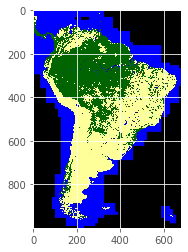

In [6]:
# Import the forest/non-forest image, and transform it to a Boolean np.array.

def fnf_labels(path):
    im = Image.open(path)
    print(im.size)
    plt.figure()
    plt.imshow(np.array(im))
    ar = np.array(im.getdata())
    
    forest = []
    for pixel in ar:
        if pixel[0] < 10 and pixel[2] < 10 and pixel[1] > 64:
            forest.append([True])
        else: 
            forest.append([False])
    forest = np.array(forest)

    return forest      

image = Image.open("images/fnf.jpg")
mapY = np.array(image)
Y = fnf_labels("images/fnf.jpg")

There are twelve features that we chose to test for relevance. The citations for the sources of this geospatial data is found in references (3-15).

1. air temperature 

2. total precipitation

3. surface pressure

4. surface water

5. u-wind (wind in the horizontal direction)

6. v-wind (wind in the vertical direction)

7. elevation 

8. soil moisture

9. subsurface moisture 

10. topographic diversity 

11. fire deforestation

12. population density 

We extract the data from twelve different datasets using the methodology described earlier for each chosen feature. We then preprocessed the data, creating normalized 1D numpy arrays of all the same size (shape 681,000 x 1). 

(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)
(681, 1000)


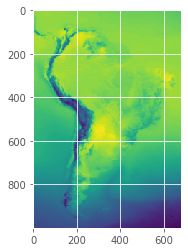

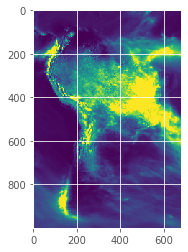

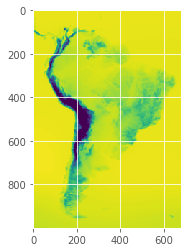

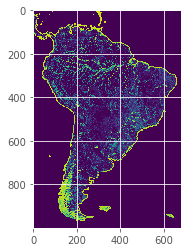

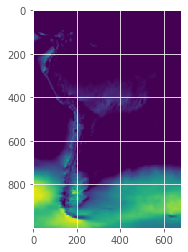

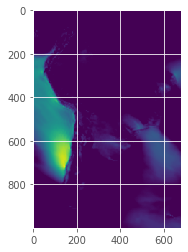

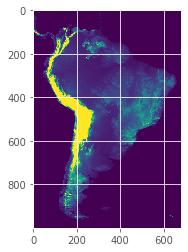

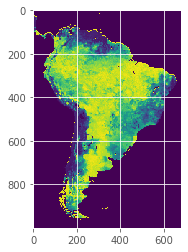

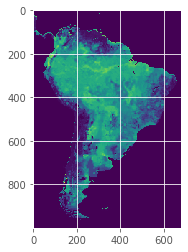

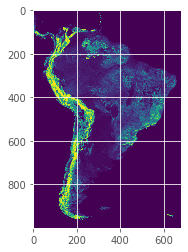

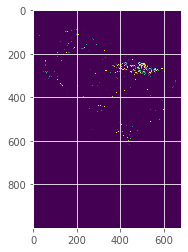

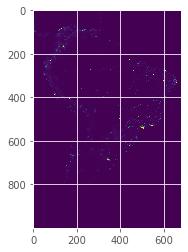

In [7]:
def feature_map(path):
    im = Image.open(path)
    print(im.size)
    plt.figure()
    plt.imshow(np.asarray(im))
    ar = np.array(im.getdata())
    min = ar.min()
    norm_max = ar.max() - min
    ar = np.float32((ar - min) / norm_max)
    ar = ar[:,None]
    return ar

F1 = feature_map("images/air-temp.jpg")

F2 = feature_map("images/total_precip.jpg")

F3 = feature_map("images/surface_pres.jpg")

F4 = feature_map("images/surface_water.jpg")

F5 = feature_map("images/u_wind.jpg")

F6 = feature_map("images/v_wind.jpg")

F7 = feature_map("images/elevation.jpg")

F8 = feature_map("images/soil_moisture.jpg")

F9 = feature_map("images/subsurface_moisture.jpg")

F10 = feature_map("images/topographic_diversity.jpg")

F11 = feature_map("images/fire_deforestation.jpg")

F12 = feature_map("images/population_density.jpg")

## Preparing Data

In order to predict whether an area can support reforestation, an Support Vector Machine (SVM) will be defined and trained, using `sklearn`. Data must be prepared in order to be fed through the model for training, testing, and prediction. This includes, in our case, flattening, splitting, and separating the data. As described earlier, we normalize each grid of coordinates into numpy arrays of shape (681,000 x 1). In order to so this, each of the twelve features in addition to the forest/non-forest grid must be flattened into a 1D numpy array. 

At the bottom of this cell, the data is then split into testing data and training data, where 1/5 is reserved for testing, a standard in the field of data science. The training data is used to train the model to recognize, and hence predict the location of forests, while the testing data is reserved to evaluate such accuracy. 

In [8]:
#Flattening and preparing data for the forested area
y = list(Y)
y = [z for x in y for z in x]

#Flattening and preparing data for air temperature
airTemp = list(F1)
airTemp = [z for x in airTemp for z in x]

#Flattening and preparing data for precipitation
precip = list(F2)
precip = [z for x in precip for z in x]

#Flattening and preparing data for surface pressure
surfPress = list(F3)
surfPress = [z for x in surfPress for z in x]

#Flattening and preparing data for surface water
surfWater = list(F4)
surfWater = [z for x in surfWater for z in x]

#Flattening and preparing data for wind in u direction
uWind = list(F5)
uWind = [z for x in uWind for z in x]

#Flattening and preparing data for wind in v direction
vWind = list(F6)
vWind = [z for x in vWind for z in x]

#Flattening and preparing data for elevation
elev = list(F7)
elev = [z for x in elev for z in x]

#Flattening and preparing data for soil moisture
soil = list(F8)
soil = [z for x in soil for z in x]

#Flattening and preparing data for subsurface moisture
subsurface = list(F9)
subsurface = [z for x in subsurface for z in x]

#Flattening and preparing data for topographic diversity
topDiv = list(F10)
topDiv = [z for x in topDiv for z in x]

#Flattening and preparing data for fire deforestation
fire = list(F11)
fire = [z for x in fire for z in x]

#Flattening and preparing data for population density
popDens = list(F12)
popDens = [z for x in popDens for z in x]

def split_data(data):
    
    l = len(data)
    lenVal = l//5
    valData = data[:lenVal]
    val = np.asarray(valData, dtype=np.float32)
    trainData = data[lenVal:]
    train = np.asarray(trainData, dtype=np.float32)
    return (val, train)

forDict = {"forest": y,
           "airTemp": airTemp,
           "precip": precip,
           "surfPress": surfPress,
           "surfWater": surfWater,
           "uWind": uWind,
           "vWind": vWind,
           "elev" : elev,
           "soil" : soil, 
           "subsurface" : subsurface,
           "topDiv" : topDiv,
           "fire" : fire,
           "popDens": popDens}

headers = ["forest", "airTemp", "precip", "surfPress", "surfWater", "uWind", 
           "vWind", "elev", "soil", "subsurface", "topDiv", "fire", "popDens"]
fdf = pd.DataFrame(forDict)
fullData = np.array([y, airTemp, precip, surfPress, surfWater, uWind, vWind, 
                     elev, soil, subsurface, topDiv, fire, popDens]).T
semiData = list(fullData)
(fn, x) = split_data(semiData)

The feature data and forest indicators are organized into data structures for use by the sklearn SVM model. 

In [9]:
def separate_objective(headers, data, objectives):
   
    features, objective, header = [], [], []
    badInd = []
    
    #Prepare the data by separating by objective/non-objective
    for elem in headers:
        header.append(elem)
    for obj in objectives:
        ind = header.index(obj)
        badInd.append(ind)
        objective.append([])
        
    #Prepare new data matrix based on the headers/objectives
    for row in range(len(data)):
        feat, objs = [], []
        for elem in range(len(data[row])):
            if elem in badInd: objs.append(data[row][elem])
            else: feat.append(data[row][elem])
        features.append(feat)
        for o in range(len(objs)):
            objective[o].append(objs[o])
    badInd.sort(reverse=True)
    for ind in badInd:
        del header[ind]
    features = np.asarray(features)
    
    #Make objectives be a tuple of the individual objectives
    for oc in range(len(objective)):
        objective[oc] = np.asarray(objective[oc])
    objective = tuple(objective)
    
    return (header, features, objective)

## Training a Forest Prediction Model

Before constructing our model, we want to determine which features of the twelve have the best predictive performance. That is, which subset of the twelve combined result in the most accurate modeling of existing forested areas. As the features were initially chosen based on suspected correlation, this process will refine the feature set, and elimiate any duds. 

For each subset of features we analyze, we will determine the mean squared error (MSE). The smaller the MSE, the more accurate the model is. Computing the MSE is faster than training and testing a full SVM for each subset of features. 

In [10]:
def mean_squared_error(pred, ground_truth):
    mse = 0
    predL, groundL = list(pred), list(ground_truth)
    for i in range(len(pred)):
        mse += (groundL[i] - predL[i])**2
    return mse / len(predL)

In the function below, the best subset of features is determined. In the function, you can specify the number of features that you want in the minimum combination. Currently, we are searching for the best subset 10 features out of 12, however you can refine the model further by choosing a smaller number of features in your subset. 

In [11]:
def predForest(headers, data):
    (forH, forD, forO) = separate_objective(headers, data, ["forest"])
    forO = forO[0]
    forO = np.asarray(forO, dtype=np.float32)
    
    #Make all the combinations of 12 headers
    combos = list(itertools.combinations(forH, 10)) # can change
    minCombo, minMSE = [], 10000
    
    #Test each combination of the headers in headers
    for combo in combos:
        combo = list(combo)
        (predH, predD, predO) = separate_objective(headers, data, combo)
        predO = list(predO)
        predO = list(map(list, zip(*predO)))
        
        #Split the data into training and testing
        (valC, trainC) = split_data(predO)
        (vPred, tPred) = split_data(forO)
        X1 = np.asarray(valC, dtype=np.float32)
        X2 = np.asarray(trainC, dtype=np.float32)
        
        #Use the LR model to fit and predict on the model
        check = LinearRegression().fit(X2, tPred)
        mse = mean_squared_error(np.matmul(X1, check.coef_.T), vPred)
        
        #Update the minimum MSE seen if necessary
        if mse < minMSE:
            minCombo = combo
            minMSE = mse
            
    return minCombo

The combination of features that produces the best model is returned. In preparing the SVM model, the array of data is reduced to an array of data with the indices of the features from this most efficient combination. The data matrix and boolean vector of forests are then broken down into training and testing data. The SVM model is created and fitted in the cell below. 

In [12]:
p = predForest(headers, fn)
print(p)

inds = []
for elem in p:
    inds.append(headers.index(elem))
    
#Prepare data matrix with the proper headers found above
X = fn.T[np.array(inds)].T
y = fn.T[0].T
y = 1*y

#Splits the data further into training and testing data
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2)

#Prepare in the SVM model to predict forested areas
clf = svm.SVC()
clf.fit(trainX, trainY)
prediction = clf.predict(testX)

['precip', 'surfWater', 'uWind', 'vWind', 'elev', 'soil', 'subsurface', 'topDiv', 'fire', 'popDens']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


As shown by the printed output, the best ten features (out of twelve) for predicting existing forest are precipiation, surface water, horizontal wind, vertical wind, elevation, soil moisture, subsurface moisture, topographical diversity, deforestation fires, and population density. By the processs of elimination, that means that air temperature and surface pressure were not shown to be relevant predictors. 

The code below tests the accuracy of the SVM model.

In [13]:
tot = 0
for i in range(len(testY)):
    if testY[i] == prediction[i]: tot += 1
"Total accuracy: %f" %(tot/len(testY))

'Total accuracy: 0.935830'

## Determining Regions for Reforestation

Having split the data earlier in order to train the model, the full set of data is reduced to the features that were decided upon above. Here we will conduct the same process as testing, but now using the full dataset. This will reveal coordinates where the model predicts forest should exist. We then subtract these coordinates from the regions where forest already grows. What remains are the locations that are unforested, but are best suited for reforestation. 

In [14]:
fullX = fullData.T[np.array(inds)].T
fullY = fullData.T[0].T
fullY = 1*fullY

possForest = clf.decision_function(fullX)

The threshold variable below sets a bar for minimum reforestability. Currently, we have it set to 0.5, which will return the top quartile of reforestable areas. This can be changed to a higher value to be more selective, or to a lower value (minimum = 0.0) to be less selective. 

In [15]:
newFor = []
thresh = 0.5 # can change selectivity threshold
forestThreshold = thresh * max(possForest)
for i in range(len(fullY)):
    if fullY[i]==0 and possForest[i] > forestThreshold: newFor.append(i)
print("New Forests: ", len(newFor))        

New Forests:  21106


checkFor is an array of booleans where the model predicts forest should be. It takes the prior list of coordinates and converts it into a boolean array. 

In [16]:
checkFor = [False]*len(fullY)
for num in newFor:
    checkFor[num] = True

The code below uses checkFor, masked by the already forested areas, to determine reforestable regions. It creates an image where already-forested regions are shown in yellow, unforested regions below the viability threshold are shown in red, and unforested regions that are good candidates from reforestation are displayed in green. 

In [17]:
newY = np.zeros((1000, 681, 3))

for i in range(len(mapY)):
    for j in range(len(mapY[0])):
        pix = mapY[i][j]
       
        if (not(pix[0]<=1 and pix[1]<=1 and pix[2]<=1)) and pix[2] < 240 and (not(pix[0]>=250 and pix[1]>=250 and pix[2]>=250)): 
            if checkFor[i*681+j]: 
                newY[i][j] = [0, 254, 0]
            elif fullY[i*681+j]:
                newY[i][j] = [254, 254, 0]
            else: 
                newY[i][j] = [254, 0, 0]
                
        else: 
            newY[i][j] = [0, 0, 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


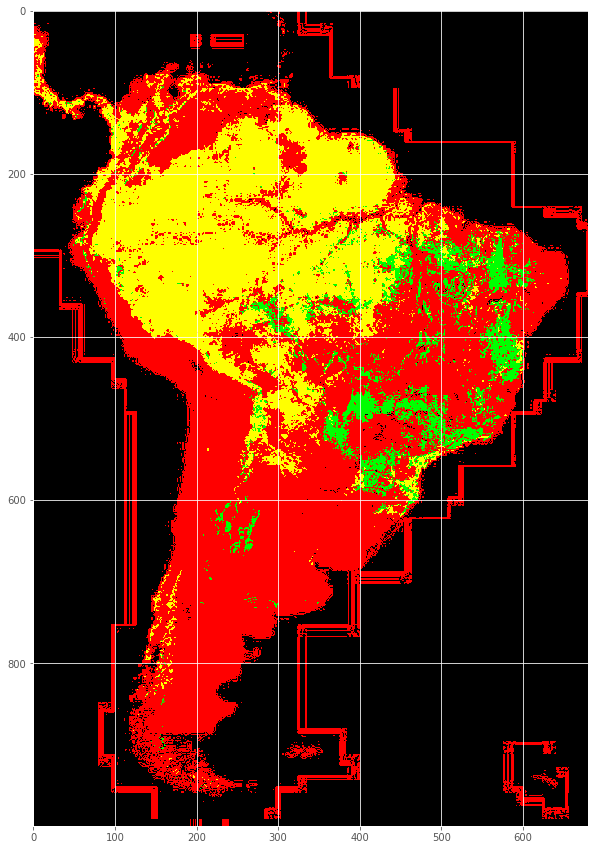

In [18]:
plt.figure(figsize=(15.0,15.0))
plt.imshow(newY)

## Discussion 

#### What We Found

In conclusion, we have solved global warming! Not really, but we made a nice picture! Our model is successfully able to take in data from dozens of different geospatial sources, determine the relevant features, predict the current location of forests, and identify new locations for optimal reforestation efforts based on a predetermined viability threshold for prioritzation. Determining the most suitable regions for reforestation will help governments and non-governmental organizations identify the most productive areas to target for regrowth. Initiatives like this can help compensate, and even reverse, the active deforestation occuring globally. Reforesting even only one of the small patches of green above could counteract the negative impact from the past year. Using a model like this can optimize the reforestation initiative to prioritize the best forestation locations. Utilizing this model, with this data, could genuinely help and make a great impact on the effort.

#### What Exists

Addressing deforestation and reforestation with data science is beginning to be explored by many other research institutions. Global Forest Watch is a online platform that uses active satellite data to monitor the changes in forestation in real time, developed by Google. Such a research platform allows us to see deforestation as it occurs, far before we typically stumble upon areas of its impact.<sup>1</sup> Moreover, using like sattelite data, researchers have looked into predicting future regions of deforestation and forest fires. A study from Cornell used neural networks and machine learning to predict deforestation by time and location using such imagery.<sup>17</sup> Furthermore, other studies have looked at the impact of potential reforestation initiatives. Published in the Molecular Diversity Preservation International journal, one study uses nonlinear regression algorithms to assess the suitability of afforestation with local species.<sup>19</sup> Similarly, a study in Science Magazine uses forest algorithms and geospatial data, as we used here, to assess the contribution of reforestation to the atmospheric balance.<sup>18</sup> Combining such information from studies like these with our predictive reforestation model could significantly contribute to an optimal, thriving reforestation effort. 

#### Where to Go Next
 
In future analysis, refinements can be made to our model. We can also consider other features; Google Earth Engine contains hundreds of geospatial datasets for consideration. Likewise, the model can be extrapolated from South America to every region on the planet with a shift of coordinates (although it will take significantly more time). Such additions would build directly off the current code by adding and changing the data inputs. 

However, more significant alterations could be made to add further predictive power and specificity. Not only could we search for reforestable regions, but we could also include contribution of the potential forest to combatting global warming as a variable we want to optimize in our prioritzation. (i.e. prioritizing not only the best regions, but the ones that also impact environmental factors the most, like biodiversity and climate-change(as addressed in above studies)). Such a model would need to include more information on what type of forests in what locations, say, produce the most oxygen to help the atmosphere. Another example would be to determine the reforestation on a far more specific level. Such a model might also determine forest type, and even tree species, when identifying the regions for reforestation. This model would also need more data on the tree species distribution in each region. Adding information like this would create a clear and actionable plan for reforestation for all interested organizations.   

While our predicitve model aids in strategizing a plan for a reforestation solution, without action it is nothing. Forests take decades to grow. The current rate of loss far exceeds the rate of growth. If we continue on the same trajectory, without a large-scale reforestation intiative the effects of deforestation may become very severe. Even the smallest of changes can make a long-run impact, and we hope information as found in this report can aid that effort. 

## References

#### Deforestation information

<sup>1</sup> [Global Forest Watch](https://www.globalforestwatch.org/topics/biodiversity)

<sup>2</sup> Nunez, Christina “Deforestation Explained” National Geographic 2.7.19

#### Data sources

<sup>3</sup> Bolten, J., W.T. Crow, X. Zhan, T.J. Jackson, and C.A. Reynolds (2010). Evaluating the Utility of Remotely Sensed Soil Moisture Retrievals for Operational Agricultural Drought Monitoring, IEEE Transactions on Geoscience and Remote Sensing, 3(1): 57-66. DOI 10.1109/JSTARS.2009.2037163 Google Scholar

<sup>4</sup> Bolten, J., and W. T. Crow (2012). Improved prediction of quasi-global vegetation conditions using remotely-sensed surface soil moisture, Geophysical Research Letters, 39: (L19406). DOI 10.1029/2012GL053470 Google Scholar

<sup>5</sup> Center for International Earth Science Information Network - CIESIN - Columbia University. 2018. Gridded Population of the World, Version 4 (GPWv4): Basic Characteristics, Revision 11. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H46M34XX. Dec 11, 2019

<sup>6</sup> Copernicus Climate Change Service (C3S) (2017): ERA5: Fifth generation of ECMWF atmospheric reanalyses of the global climate. Copernicus Climate Change Service Climate Data Store (CDS), Dec 11 2019 https://cds.climate.copernicus.eu/cdsapp#!/home

<sup>7</sup> Entekhabi, D, Njoku, EG, O'Neill, PE, Kellogg, KH, Crow, WT, Edelstein, WN, Entin, JK, Goodman, SD, Jackson, TJ, Johnson, J, Kimball, J, Piepmeier, JR, Koster, RD, Martin, N, McDonald, KC, Moghaddam, M, Moran, S, Reichle, R, Shi, JC, Spencer, MW, Thurman, SW, Tsang, L & Van Zyl, J (2010). The soil moisture active passive (SMAP) mission, Proceedings of the IEEE, 98(5): 704-716. DOI 10.1109/JPROC.2010.2043918 Article

<sup>8</sup> Farr, T.G., Rosen, P.A., Caro, E., Crippen, R., Duren, R., Hensley, S., Kobrick, M., Paller, M., Rodriguez, E., Roth, L., Seal, D., Shaffer, S., Shimada, J., Umland, J., Werner, M., Oskin, M., Burbank, D., and Alsdorf, D.E., 2007, The shuttle radar topography mission: Reviews of Geophysics, v. 45, no. 2, RG2004, at https://doi.org/10.1029/2005RG000183.

<sup>9</sup> I. E. Mladenova, J.D. Bolten, W.T. Crow, M.C. Anderson, C.R. Hain, D.M. Johnson, R. Mueller (2017). Intercomparison of Soil Moisture, Evaporative Stress, and Vegetation Indices for Estimating Corn and Soybean Yields Over the U.S., IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 10(4): 1328-1343, DOI 10.1109/JSTARS.2016.2639338

<sup>10</sup> Jean-Francois Pekel, Andrew Cottam, Noel Gorelick, Alan S. Belward, High-resolution mapping of global surface water and its long-term changes. Nature 540, 418-422 (2016). (doi:10.1038/nature20584)

<sup>11</sup> Masanobu Shimada, Takuya Itoh, Takeshi Motooka, Manabu Watanabe, Shiraishi Tomohiro, Rajesh Thapa, and Richard Lucas, "New Global Forest/Non-forest Maps from ALOS PALSAR Data (2007-2010)", Remote Sensing of Environment, 155, pp. 13-31, December 2014. doi:10.1016/j.rse.2014.04.014.
https://science.sciencemag.org/content/365/6448/76/tab-figures-data

<sup>12</sup> MODIS Collection 6 NRT Hotspot / Active Fire Detections MCD14DL. Available on-line https://earthdata.nasa.gov/firms. DOI: 10.5067/FIRMS/MODIS/MCD14DL.NRT.006

<sup>13</sup> O'Neill, P. E., S. Chan, E. G. Njoku, T. Jackson, and R. Bindlish (2016). SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 4. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. DOI 10.5067/ZX7YX2Y2LHEB

<sup>14</sup> Sazib, N., I. E. Mladenova, J.D. Bolten (2018). Leveraging the Google Earth Engine for Drought Assessment Using Global Soil Moisture Data. Remote Sensing, 10(8), p.1265. DOI 10.3390/rs10081265 Google Scholar

<sup>15</sup> Theobald, D. M., Harrison-Atlas, D., Monahan, W. B., & Albano, C. M. (2015). Ecologically-relevant maps of landforms and physiographic diversity for climate adaptation planning. PloS one, 10(12), e0143619

#### API Documentation

<sup>16</sup> [Google Earth Engine Developers Guide](https://developers.google.com/earth-engine)

<sup>17</sup> [Google Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/)

#### Future Reading

<sup>17</sup> Ahmadi, Vahid. [Deforestation Prediction Using Neural Networks and Satellite Imagery in a Spatial Information System](https://arxiv.org/abs/1803.02489). Computers and Society. 7 March 2018 arXiv:1803.02489

<sup>18</sup> Jean-Francois Bastin, Yelena Finegold, Claude Garcia, Danilo Mollicone, Marcelo Rezende, Devin Routh, Constantin M. Zohner, Thomas W. Crowther [The Global Tree Restoration Potential](https://science.sciencemag.org/content/365/6448/76/tab-figures-data). Science Magazine July 5, 2019

<sup>19</sup> Yuling Chen, Baoguo Wu, Dong Chen, and Yan Qi, Using Machine Learning to Assess Site Suitability for Afforestation with Particular Species. Molecular Diversity Preservation International. Received: 5 June 2019; Accepted: 25 August 2019; Published: 27 August 2019

